In [218]:
import re
import spacy
import requests
import pandas as pd
from bs4 import BeautifulSoup
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [237]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk  

textsample ="BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage. The service maintains 50 foreign news bureaus with more than 250 correspondents around the world. Fran Unsworth has been director of news and current affairs since January 2018. In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019. BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London. Parliamentary coverage is produced and broadcast from studios in London. Through BBC English Regions, the BBC also has regional centres across England and national news centres in Northern Ireland, Scotland and Wales. All nations and English regions produce their own local news programmes and other current affairs and sport programmes."  

sentences = nltk.sent_tokenize(textsample)  
words = nltk.word_tokenize(textsample)  
sentences 
[w for w in words if w.isalpha()]

In [239]:
sentences

['BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world.',
 "The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.",
 'The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.',
 'Fran Unsworth has been director of news and current affairs since January 2018.',
 'In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019.',
 'BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London.',
 'Parliamentary coverage is produced and broadcast from studios in London.',
 'Through BBC English Regions, the BBC also has regional centres across England and 

In [240]:
df = pd.DataFrame(sentences)
df.to_csv("s.csv", index=False)

In [241]:
s = pd.read_csv("s.csv")
s.shape

(9, 1)

In [242]:
s

,0
0,BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world.
1,"The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage."
2,The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.
3,Fran Unsworth has been director of news and current affairs since January 2018.
4,"In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019."
5,"BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London."
6,Parliamentary coverage is produced and broadcast from studios in London.
7,"Through BBC English Regions, the BBC also has regional centres across England and national news centres in Northern Ireland, Scotland and Wales."
8,All nations and English regions produce their own local news programmes and other current affairs and sport programmes.


In [243]:
# exact sentence example
nlp = spacy.load('en_core_web_sm')

doc = nlp("The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
department ... nsubj
is ... ROOT
the ... det
world ... poss
's ... case
largest ... amod
broadcast ... compound
news ... compound
organisation ... attr
and ... cc
generates ... conj
about ... advmod
120 ... nummod
hours ... dobj
of ... prep
radio ... nmod
and ... cc
television ... conj
output ... pobj
each ... det
day ... npadvmod
, ... punct
as ... advmod
well ... advmod
as ... cc
online ... compound
news ... compound
coverage ... dobj
. ... punct


In [244]:
def get_entities(sent):

  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
   #############################################################

  return [ent1.strip(), ent2.strip()]

In [245]:
get_entities("The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.")

['department', 'well online news coverage']

In [246]:
entity_pairs = []

In [247]:
entity_pairs[10:20]

[]

In [248]:
entity_pairs

[]

In [249]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [250]:
# verb
get_relation("The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.")

'is'

In [252]:
# the column name is 0
relations = [get_relation(i) for i in tqdm(s['0'])]

100%|██████████| 9/9 [00:00<00:00, 101.60it/s]


In [253]:
entity_pairs = []

for i in tqdm(s["0"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 9/9 [00:00<00:00, 68.48it/s]


In [254]:
entity_pairs[10:20]

[]

In [256]:
# verb count
pd.Series(relations).value_counts()[:50]

is               2
maintains        1
been             1
reported in      1
housed within    1
produced         1
has regional     1
produce          1
dtype: int64

In [257]:
sentences

['BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world.',
 "The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.",
 'The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.',
 'Fran Unsworth has been director of news and current affairs since January 2018.',
 'In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019.',
 'BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London.',
 'Parliamentary coverage is produced and broadcast from studios in London.',
 'Through BBC English Regions, the BBC also has regional centres across England and 

In [258]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [259]:
kg_df.head(5)

,source,target,edge
0,BBC News,current British Broadcasting world,is
1,department,well online news coverage,is
2,service,250 news world,maintains
3,Fran Unsworth,current January,been
4,Ofcom BBC,2018 March,reported in


In [260]:
kg_df

,source,target,edge
0,BBC News,current British Broadcasting world,is
1,department,well online news coverage,is
2,service,250 news world,maintains
3,Fran Unsworth,current January,been
4,Ofcom BBC,2018 March,reported in
5,domestic news divisions,central Broadcasting London,housed within
6,Parliamentary coverage,London,produced
7,BBC English BBC,national Northern Ireland,has regional
8,nations,local news programmes,produce


In [ ]:
# Make a search with the Wikipedia API

In [261]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

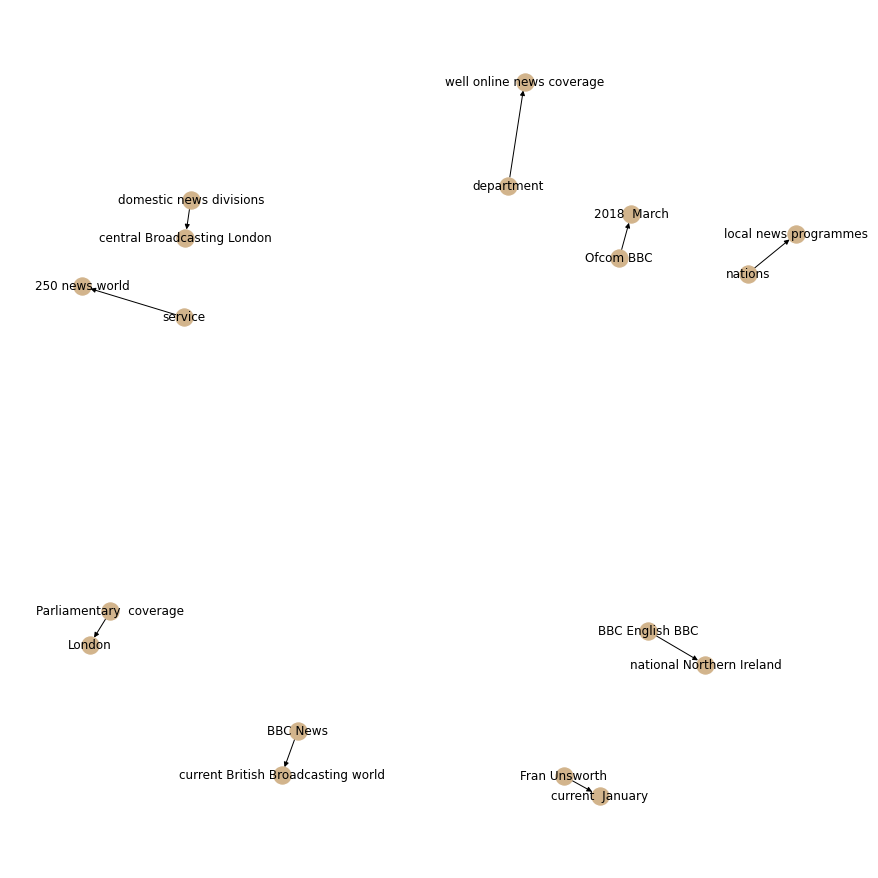

In [262]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='tan', edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

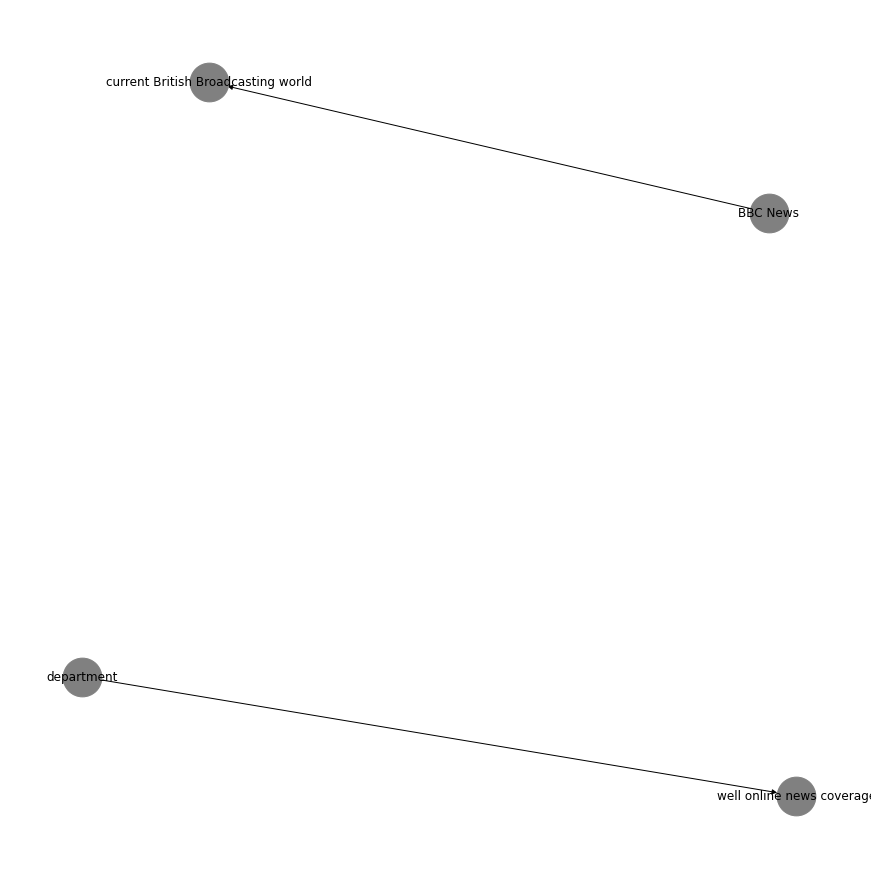

In [264]:
H=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, k = 0.9) # k regulates the distance between nodes
nx.draw(H, with_labels=True, node_color='grey', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

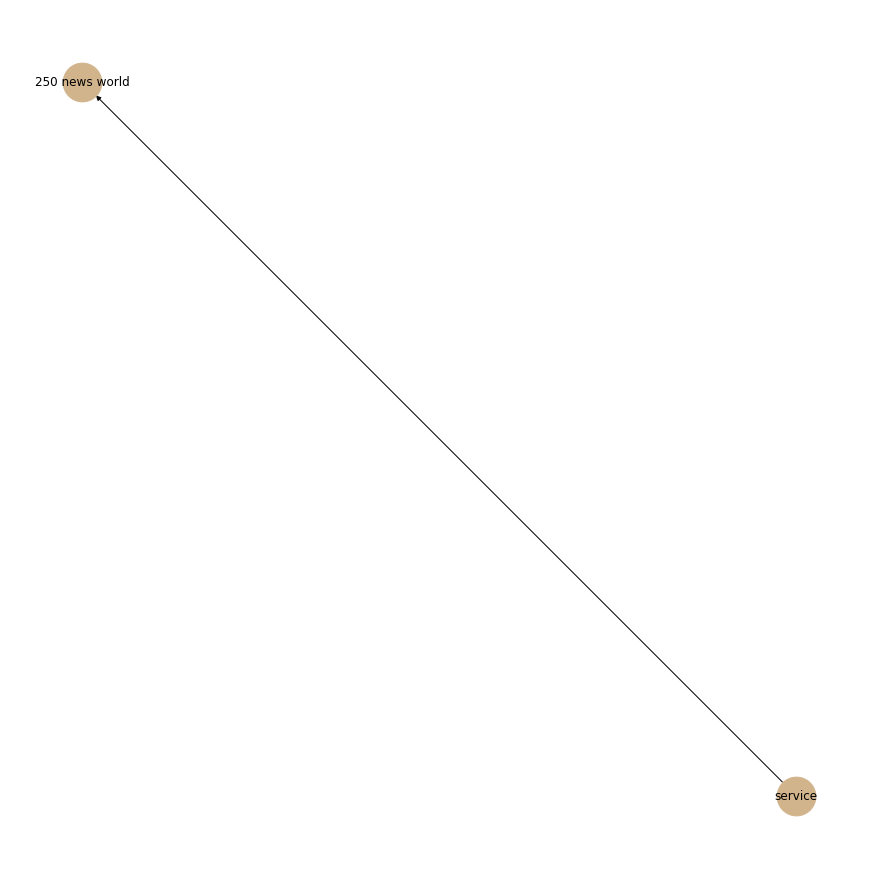

In [266]:
I=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="maintains"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(I, k = 0.5)
nx.draw(I, with_labels=True, node_color='tan', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()